# Why do we care about uncertainty decomposition?

- epistemic and aleatoric uncertainty are reduced in different ways
- adding more training data will reduce epistemic uncertainty
- aleatoric uncertainty can be reduced by collecting more refined measurements or additional features, but *not* just with additional data points
- the goal of this notebook is to show that seeing more training points will reduce epistemic uncertainty, but not aleatoric

In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import scipy.stats
from keras import backend as K
from keras.models import Model
from keras import optimizers
import numpy as np
import os, pickle, sys, time
from BBalpha_dropout import *
from collections import defaultdict
from keras.models import load_model
from numpy import ma
from timeit import default_timer as timer

np.random.seed(0)

/remote/mlsalt-2017/lrc45/Envs/concretedropout/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
n_train = 1000
n_val = 100

In [3]:
lengthscale = np.linspace(2, 4, 5)
reps = 3
sigma = 0.5
mu = 4

test_point = np.array([[0, mu]])
results_aleatoric = defaultdict(list)
results_epistemic = defaultdict(list)
results_predictive = defaultdict(list)
results_pred = defaultdict(list)

In [4]:
# MC sample parameters
K_mc = 10
K_test = 100

# network parameters
nb_layers = 2
nb_units = 100
p = 0.5
wd = 1e-6
nb_classes =4
dropout = 'MC'
alpha = 0.5
epochs = 5

In [5]:
def generate_points(mu, sigma, l, n):
    """ 
    Generate data points according to 4 classes, n points in each class:
    """
    class1 = np.stack((np.random.normal(mu, sigma, n), 
                   np.random.normal(mu, sigma, n)), axis=-1)
    class1_y = np.stack((np.ones(n,), np.zeros(n,), 
                         np.zeros(n,), np.zeros(n,)), axis=-1)
    class2 = np.stack((np.random.normal(-mu, sigma, n), 
                       np.random.normal(mu, sigma, n)), axis=-1)
    class2_y = np.stack((np.zeros(n,), np.ones(n,), 
                         np.zeros(n,), np.zeros(n,)), axis=-1)
    class3 = np.stack((np.random.normal(0, sigma, n),
                       np.random.exponential(l, n)), axis=-1)
    class3_y = np.stack((np.zeros(n,), np.zeros(n,), 
                         np.ones(n,), np.zeros(n,)), axis=-1)
    class4 = np.stack((np.random.normal(0, sigma, n),
                       np.random.exponential(l, n)), axis=-1)
    class4_y = np.stack((np.zeros(n,), np.zeros(n,), 
                         np.zeros(n,), np.ones(n,)), axis=-1)
    x = np.concatenate((class1, class2, class3, class4), axis=0)
    y = np.concatenate((class1_y, class2_y, class3_y, class4_y), axis=0)
    return (x, y)

In [6]:
if all([os.path.isfile(f) for f in ['results_aleatoric.p', 'results_epistemic.p',
                                    'results_predictive.p', 'results_pred.p']]):
    results_aleatoric = pickle.load(open('results_aleatoric.p', 'rb'))
    results_epistemic = pickle.load(open('results_epistemic.p', 'rb'))
    results_predictive = pickle.load(open('results_predictive.p', 'rb'))
    results_pred = pickle.load(open('results_pred.p', 'rb'))
else:
    for r in range(reps):
        for l in lengthscale:
            print('Rep: {}, l={}'.format(r, l))
            x_train, y_train = generate_points(mu, sigma, l, n_train)
            x_val, y_val = generate_points(mu, sigma, l, n_val)
            ytraindup = np.squeeze(np.concatenate(K_mc * [y_train[:, None]], axis=1)) # N x K_mc x D
            yvaldup= np.squeeze(np.concatenate(K_mc * [y_val[:, None]], axis=1)) # N x K_mc x D

            # build the model
            input_shape = (2, )
            inp = Input(shape=input_shape)
            D = Dropout_mc
            layers = []
            for ii in range(nb_layers):
                if True: #ii != 0:
                    layers.append(D(p))
                layers.append(Dense(nb_units, activation='relu', kernel_regularizer=l2(wd)))
            layers.append(D(p))
            layers.append(Dense(nb_classes, kernel_regularizer=l2(wd))) # these are logit activations!
            mc_logits = GenerateMCSamples(inp, layers, K_mc)
            loss_function = bbalpha_softmax_cross_entropy_with_mc_logits(alpha)
            model = Model(inputs=inp, outputs=mc_logits)
            opt = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
            model.compile(optimizer=opt, loss=loss_function, 
                          metrics=['accuracy', loss_function, metric_avg_acc, metric_avg_ll])

            # training loop
            results = defaultdict(list)
            max_acc = 0.
            max_acc_ep = 0
            ep = 0
            tic = timer()
            while ep < max(2 * max_acc_ep, epochs):
                epoch_start = timer()
                history = model.fit(x_train, ytraindup, verbose=0,
                                    initial_epoch=ep, epochs=ep+1,
                                    validation_data=(x_val, yvaldup))
                epoch_end = timer()
                results['train_N'].append(x_train.shape[0]) 
                results['val_N'].append(x_val.shape[0]) 
                results['time'].append(epoch_end - epoch_start)
                results['train_total_loss'].extend(history.history['loss'])
                results['train_bbalpha_loss'].extend(history.history['bbalpha_loss'])
                results['train_acc'].extend(history.history['acc'])
                results['train_avg_acc'].extend(history.history['metric_avg_acc'])
                results['train_ll'].extend(history.history['metric_avg_ll'])
                results['val_total_loss'].extend(history.history['val_loss'])
                results['val_bbalpha_loss'].extend(history.history['val_bbalpha_loss'])
                results['val_acc'].extend(history.history['val_acc'])
                results['val_avg_acc'].extend(history.history['val_metric_avg_acc'])
                results['val_ll'].extend(history.history['val_metric_avg_ll'])

                val_avg_acc = results['val_avg_acc'][-1]
                if val_avg_acc > max_acc:
                    max_acc = val_avg_acc
                    max_acc_ep = ep
                    model.save('toy-model.h5')
                    print("Updating max_acc_ep: {}".format(max_acc_ep))
                print("max_acc_ep: {}\t max_acc: {:.3f}".format(max_acc_ep, max_acc))
                ep += 1

            toc = timer()
            print('Time elapsed in seconds: {}'.format(toc-tic))

            # load the saved model with early stopping, and build test model
            file_name = 'toy-model.h5'
            model = load_model(file_name, custom_objects={'bbalpha_loss': bbalpha_softmax_cross_entropy_with_mc_logits(alpha),
                                                          'metric_avg_acc': metric_avg_acc,
                                                          'metric_avg_ll': metric_avg_ll})
            mc_logits = GenerateMCSamples(inp, model.layers[1:-1], K_test) # repeats stochastic layers nb_test
            mc_softmax = Activation('softmax')(mc_logits)  # softmax is over last dim
            test_model = Model(inputs=inp, outputs=mc_softmax) # check the dimensions of this model

            # predict on the test point
            pred = test_model.predict(test_point)
            avg_pc = np.mean(pred, axis=1)
            predictive = - np.sum(avg_pc * ma.log2(avg_pc).filled(0), axis=-1)
            aleatoric = - 1/K_test * np.sum(pred * ma.log2(pred).filled(0), axis=(1,2))
            epistemic = predictive - aleatoric

            # store results
            results_aleatoric[l].extend(aleatoric)
            results_epistemic[l].extend(epistemic)
            results_predictive[l].extend(predictive)
            results_pred[l].append(pred)


Rep: 0, l=2.0
Updating max_acc_ep: 0
max_acc_ep: 0	 max_acc: 0.718
max_acc_ep: 0	 max_acc: 0.718
Updating max_acc_ep: 2
max_acc_ep: 2	 max_acc: 0.725
max_acc_ep: 2	 max_acc: 0.725
Updating max_acc_ep: 4
max_acc_ep: 4	 max_acc: 0.735
max_acc_ep: 4	 max_acc: 0.735
max_acc_ep: 4	 max_acc: 0.735
Updating max_acc_ep: 7
max_acc_ep: 7	 max_acc: 0.745
max_acc_ep: 7	 max_acc: 0.745
Updating max_acc_ep: 9
max_acc_ep: 9	 max_acc: 0.750
max_acc_ep: 9	 max_acc: 0.750
max_acc_ep: 9	 max_acc: 0.750
max_acc_ep: 9	 max_acc: 0.750
max_acc_ep: 9	 max_acc: 0.750
max_acc_ep: 9	 max_acc: 0.750
max_acc_ep: 9	 max_acc: 0.750
max_acc_ep: 9	 max_acc: 0.750
max_acc_ep: 9	 max_acc: 0.750
Time elapsed in seconds: 17.43298496864736
Rep: 0, l=2.5
Updating max_acc_ep: 0
max_acc_ep: 0	 max_acc: 0.720
Updating max_acc_ep: 1
max_acc_ep: 1	 max_acc: 0.752
max_acc_ep: 1	 max_acc: 0.752
max_acc_ep: 1	 max_acc: 0.752
max_acc_ep: 1	 max_acc: 0.752
Time elapsed in seconds: 7.550457403063774
Rep: 0, l=3.0
Updating max_acc_ep: 

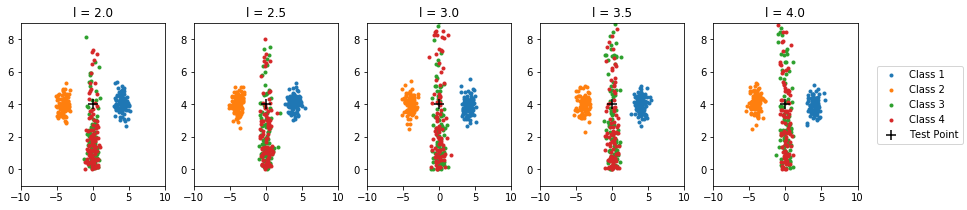

In [13]:
# plot the distributions
f, axes = plt.subplots(1, 5, figsize=(15, 3))
n_train = 100
for ax, l in zip(axes, lengthscale):
    classes = []
    x_train, y_train = generate_points(mu, sigma, l, n_train)
    for ii in range(4):
        points = x_train[np.where(np.argmax(y_train, axis=1)==ii)]
        s = ax.scatter(points[:,0], points[:,1], marker='.')
        classes.append(s)
    s = ax.scatter(test_point[:, 0], test_point[:, 1], marker='+', s=100, c='k')
    classes.append(s)
    ax.set_title('l = {}'.format(l))
    ax.set_xlim([-10, 10])
    ax.set_ylim([-1, 9])
f.legend(classes, ('Class 1', 'Class 2', 'Class 3', 'Class 4', 'Test Point'), 'right')
f.savefig('data_distribution.png', dpi=600)

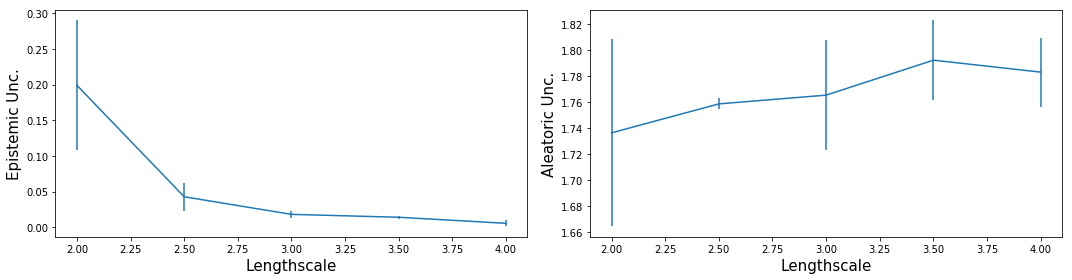

In [12]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))
ax1.errorbar(lengthscale, [np.mean(results_epistemic[l]) for l in lengthscale],
             [np.std(results_epistemic[l]) for l in lengthscale])
ax1.set_xlabel("Lengthscale", fontsize=15)
ax1.set_ylabel('Epistemic Unc.', fontsize=15)
# ax1.set_yscale("log", nonposy='clip')
ax2.errorbar(lengthscale, [np.mean(results_aleatoric[l]) for l in lengthscale],
              [np.std(results_aleatoric[l]) for l in lengthscale])
ax2.set_xlabel("Lengthscale", fontsize=15)
ax2.set_ylabel('Aleatoric Unc.', fontsize=15)
# ax2.set_yscale("log", nonposy='clip')
f.tight_layout()
f.savefig('epistemic_aleatoric.png', dpi=600)

In [11]:
pickle.dump(results_aleatoric, open('results_aleatoric.p', 'wb'))
pickle.dump(results_epistemic, open('results_epistemic.p', 'wb'))
pickle.dump(results_predictive, open('results_predictive.p', 'wb'))
pickle.dump(results_pred, open('results_pred.p', 'wb'))